In [15]:
# @title Loading data
#Non-incremental online learning of parallelizable Reservoir

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/flt_sp500.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data, dtype=float)

#standardization

mean_value = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)

data = (data - mean_value) / std_dev

data = data.T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# @title Loading optuna

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

Data length: (503, 378)


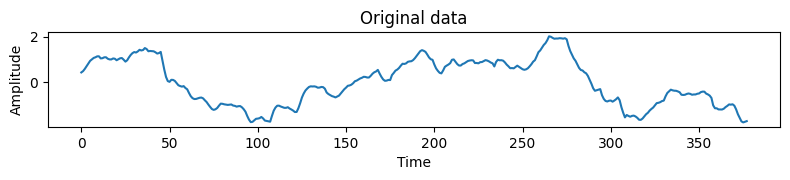

In [17]:
# @title visualization of data

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv

print('Data length:',data.shape)

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[4,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [18]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

def generate_random_binary_matrix(N_x, dim, density, seed_value_binary):

    num_ones = int(N_x*dim * density)
    matrix = np.zeros(N_x*dim, dtype=int)

    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*dim, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, dim))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x)+Wbias \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):


    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    for m in range(train_U.shape[0]):

        x = np.zeros(N_x)

        for n in range(T_train):

            # reservoir state vector
            x = Reservoir(np.dot(Win,train_U[m,n,:]),x,W,alpha,bias_scale)

            # teacher data
            d = train_D[m,n,:]


            if n > discard_len:  # discard the first part of the data
                 X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

        x_special_vec[m,:] = x

    return X_XT, D_XT,x_special_vec

########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test,bias_scale):

    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha,bias_scale)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

In [19]:
# @title Definition of Model selection（Optuna）

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

####################################################
#indicator function

def sign_indicator(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def sign_onezero(x):
    if x > 0:
        return 1
    elif x < 0:
        return 0
    else:
        return 0

def heaviside_ratio(A, B):
    product = A * B
    # heaviside(x, 0): x > 0 → 1, x == 0 → 0, x < 0 → 0
    heaviside = np.heaviside(product, 0)
    ratio = np.mean(heaviside)
    return ratio

####################
# Objective function

def objective(trial):
    lag = trial.suggest_int("lag", max_lag, max_lag)
    dim = trial.suggest_int("dim", max_dim, max_dim)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.3)
    rho = trial.suggest_float("rho", 0, 1.3)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.3, 1.3)

###############

    T_0 = T_train + lag * (dim-1)

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

    data_delay_train = np.zeros((train_set.shape[0],T_train+1,dim), dtype=float)
    test_Y           = np.zeros((train_set.shape[0],T_test,test_num))
    test_D           = np.zeros((train_set.shape[0],T_test,test_num))
###############
#Convert data to a delay coordinate system


    for i in range(dim):

        data_delay_train[:,:,i] = train_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag Step-delayed time series


# Initialization of training data

    train_U = np.zeros((train_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((train_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

# Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    data_delay_train_resvec = np.zeros((train_set.shape[0],T_train+1,dim,test_num), dtype=float)
    updown_pred             = np.zeros((train_set.shape[0],test_num))
    updown_ans              = np.zeros((train_set.shape[0],test_num))

###############
#Convert test data to a delay coordinate system

    for t in range(test_num):

        for i in range(dim):

            data_delay_train_resvec[:,:,i,t] = train_set[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

              # Initialization of training data

        train_U = np.zeros((train_set.shape[0],T_train,dim), dtype=float)
        train_D = np.zeros((train_set.shape[0],T_train,dim), dtype=float)

    #Input/output of training data

        train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
        train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)


################
#Model selection

        for j in range (train_set.shape[0]):

            for i in range(dim):

                data_delay_test[:,i,t] = train_set[j,T_0-i*lag+t:
                                                T_0+T_test-i*lag+t+1] # i*lag step delayed time series


      #Generate estimated data


            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special_vec[j,:], \
                                          Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[j,:,t] = tentative_test_Y[:,0,t]
            test_D[j,:,t] = data_delay_test[1:T_test+1,0,t]


########################
#up or down

            updown_pred[j,t] = sign_indicator(test_Y[j,T_test-1,t]-data_delay_test[0,0,t])
            updown_ans[j,t] = sign_indicator(test_D[j,T_test-1,t]-data_delay_test[0,0,t])

    return  heaviside_ratio(updown_pred, updown_ans)

CPU times: user 40 µs, sys: 0 ns, total: 40 µs
Wall time: 44.8 µs


In [20]:
# @title Bayesian optimization of Reservoir

%%time

T_train      = 60   # Training period
T_test       = 1    # Forecast period
discard_len  = 15   # Number of steps not learned at the beginning (not important)
initial_time = 0

n_trials    = 60    # Number of times to test with optuna (generate autocorrelation for this number of times)
#Repeat trials until lag and dim become stable

Node       = 30     # Reservoir Node
max_lag    = 1
max_dim    = 2
test_num   = 1

MAX_TRIALS = 30

###############################

print("data.shape:",data.shape)
print("data length from initial_time:",data[:,initial_time:].shape[1])
print("data length for one train-test trial:",T_train+max_lag*max_dim+2*T_test+test_num)

###############################
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mean_score     = []
score          = []

mean_accuracy  = []
mean_f1        = []
mean_precision = []
mean_recall    = []
accuracy  = []
f1        = []
precision = []
recall    = []


for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")

    train_set = data[:,initial_time+trial:initial_time+T_train+max_lag*max_dim+2*T_test+test_num+trial]

    # Early stopping
    def stop_callback(study, trial):

        if study.best_value > 0.63:
            study.stop()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials, callbacks=[stop_callback])

    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag  = trial.params["lag"]
    dim  = trial.params["dim"]
    N_x  = trial.params["N_x"]
    beta = trial.params["beta"]
    density = trial.params["density"]
    input_scale = trial.params["input_scale"]
    rho         = trial.params["rho"]
    alpha       = trial.params["alpha"]
    seed_value    = trial.params["seed_value"]
    bias_scale    = trial.params["bias_scale"]

###################################
##Test phase
###################################
    #prediction for one step ahead

    #T_0 = T_train+lag*(dim-1)+1+test_num-1

    #prediction for T_test step ahead
    T_0 = T_train+lag*(dim-1)+T_test+test_num-1

    Win = input_matrix(N_x,seed_value,input_scale,dim)
    W   = recurrent_matrix(N_x, density, rho,seed_value)

    data_delay_train = np.zeros((train_set.shape[0],T_train+1,dim), dtype=float)

    ###############################
    #Convert test data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,:,i] = train_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((train_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((train_set.shape[0],T_train,dim), dtype=float)


    #Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

    #Generate output weight matrix
    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

    ######################################

    data_delay_train_resvec = np.zeros((T_train+1,dim,test_num), dtype=float)
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    test_Y                  = np.zeros((T_test,test_num))
    test_D                  = np.zeros((T_test,test_num))
    tentative_test_Y        = np.zeros((T_test,dim,test_num))

    updown_pred                  = np.zeros((train_set.shape[0],test_num),dtype=float)
    updown_ans                   = np.zeros((train_set.shape[0],test_num),dtype=float)
    updown_ans_select            = np.zeros((train_set.shape[0],test_num),dtype=float)
    updown_pred_select           = np.zeros((train_set.shape[0],test_num),dtype=float)
    heaviside_select             = np.zeros((train_set.shape[0],test_num),dtype=float)
    #####################################################
    #Convert predictive data to a delay coordinate system

    for j in range (train_set.shape[0]):

        for t in range(test_num):

            for i in range(dim):

                  data_delay_train_resvec[:,i,t] = train_set[j,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

        # Initialization of training data

            train_U = np.zeros((1,T_train,dim), dtype=float)
            train_D = np.zeros((1,T_train,dim), dtype=float)

        #Input/output of training data

            train_U[0,:,:] = data_delay_train_resvec[:T_train,:,t]
            train_D[0,:,:] = data_delay_train_resvec[1:T_train+1,:,t]

        ##The last time data of the training data output must overlap with the test data!

        #Ridge
            X_XT = np.zeros((N_x, N_x))
            D_XT = np.zeros((dim, N_x))
            x_special = np.zeros((1,N_x))

            _, _,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)


            x_special = x_special.flatten()

            for i in range(dim):

                  data_delay_test[:,i,t] = train_set[j,T_0+t-i*lag
                                                :T_0+t+T_test-i*lag+1] # i*lag step delayed time series


          #Predictive data generation

            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special,Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[:,t] = tentative_test_Y[:,0,t]
            test_D[:,t] = data_delay_test[1:T_test+1,0,t]

    ########################
    #up or down

            updown_pred[j,t]      = sign_onezero(test_Y[T_test-1,t]-data_delay_test[0,0,t])
            updown_ans[j,t] = sign_onezero(test_D[T_test-1,t]-data_delay_test[0,0,t])

    accuracy.append(accuracy_score(updown_ans, updown_pred))
    f1.append(f1_score(updown_ans, updown_pred))
    precision.append(precision_score(updown_ans, updown_pred))
    recall.append(recall_score(updown_ans, updown_pred))

    mean_accuracy.append(np.mean(accuracy))
    mean_f1.append(np.mean(f1))
    mean_precision.append(np.mean(precision))
    mean_recall.append(np.mean(recall))

    print(f"Accuracy:  {accuracy[-1]:.3f}")
    print(f"F1 Score:  {f1[-1]:.3f}")
    print(f"Precision: {precision[-1]:.3f}")
    print(f"Recall:    {recall[-1]:.3f}")

    print(f"Mean Accuracy:  {mean_accuracy[-1]:.3f}")
    print(f"Mean F1 Score:  {mean_f1[-1]:.3f}")
    print(f"Mean Precision: {mean_precision[-1]:.3f}")
    print(f"Mean Recall:    {mean_recall[-1]:.3f}")

[I 2025-10-14 05:17:28,115] A new study created in memory with name: no-name-ce9bf5ed-b893-4d5a-b5a2-0197603515f1


data.shape: (503, 378)
data length from initial_time: 378
data length for one train-test trial: 65
Trial 1/30


[I 2025-10-14 05:17:33,805] Trial 0 finished with value: 0.9383697813121272 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.9395007111529028, 'input_scale': 0.4317114443964299, 'rho': 1.1480179352584758, 'alpha': 0.16484773522508045, 'seed_value': 50.26405495389302, 'bias_scale': -0.18848573741080443}. Best is trial 0 with value: 0.9383697813121272.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.9395007111529028, 'input_scale': 0.4317114443964299, 'rho': 1.1480179352584758, 'alpha': 0.16484773522508045, 'seed_value': 50.26405495389302, 'bias_scale': -0.18848573741080443},
  'value': 0.9383697813121272,


[I 2025-10-14 05:17:37,690] A new study created in memory with name: no-name-1a17be5f-1cf6-424c-bf2c-8f3c76fa5b9b


Accuracy:  0.942
F1 Score:  0.256
Precision: 0.556
Recall:    0.167
Mean Accuracy:  0.942
Mean F1 Score:  0.256
Mean Precision: 0.556
Mean Recall:    0.167
Trial 2/30


[I 2025-10-14 05:17:41,013] Trial 0 finished with value: 0.9383697813121272 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.14171547232127857, 'input_scale': 0.0396673738848228, 'rho': 0.9326432263558356, 'alpha': 0.9328779279491869, 'seed_value': 79.42348017810392, 'bias_scale': 0.5353130327872659}. Best is trial 0 with value: 0.9383697813121272.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.14171547232127857, 'input_scale': 0.0396673738848228, 'rho': 0.9326432263558356, 'alpha': 0.9328779279491869, 'seed_value': 79.42348017810392, 'bias_scale': 0.5353130327872659},
  'value': 0.9383697813121272,


[I 2025-10-14 05:17:44,396] A new study created in memory with name: no-name-6968aa5a-12d4-4f82-9d93-6194352ae428


Accuracy:  0.869
F1 Score:  0.459
Precision: 0.596
Recall:    0.373
Mean Accuracy:  0.906
Mean F1 Score:  0.358
Mean Precision: 0.576
Mean Recall:    0.270
Trial 3/30


[I 2025-10-14 05:17:50,020] Trial 0 finished with value: 0.852882703777336 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.10148607144715759, 'input_scale': 0.5596203469982506, 'rho': 0.49964182382323713, 'alpha': 0.1453111746012392, 'seed_value': 27.336673120212605, 'bias_scale': -0.45157429398196647}. Best is trial 0 with value: 0.852882703777336.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.10148607144715759, 'input_scale': 0.5596203469982506, 'rho': 0.49964182382323713, 'alpha': 0.1453111746012392, 'seed_value': 27.336673120212605, 'bias_scale': -0.45157429398196647},
  'value': 0.852882703777336,


[I 2025-10-14 05:17:54,483] A new study created in memory with name: no-name-4442b5c9-8f07-4fff-87f9-9bf5772b6c30


Accuracy:  0.732
F1 Score:  0.192
Precision: 0.727
Recall:    0.110
Mean Accuracy:  0.848
Mean F1 Score:  0.302
Mean Precision: 0.626
Mean Recall:    0.217
Trial 4/30


[I 2025-10-14 05:17:57,291] Trial 0 finished with value: 0.8667992047713717 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7450846665097205, 'input_scale': 0.6803891981871218, 'rho': 0.1525388249352686, 'alpha': 0.9016581577254106, 'seed_value': 2.1712101732502376, 'bias_scale': 0.6994169751793176}. Best is trial 0 with value: 0.8667992047713717.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7450846665097205, 'input_scale': 0.6803891981871218, 'rho': 0.1525388249352686, 'alpha': 0.9016581577254106, 'seed_value': 2.1712101732502376, 'bias_scale': 0.6994169751793176},
  'value': 0.8667992047713717,


[I 2025-10-14 05:17:58,829] A new study created in memory with name: no-name-6e9d65c3-4be0-4230-843b-328417936b84


Accuracy:  0.819
F1 Score:  0.785
Precision: 0.912
Recall:    0.689
Mean Accuracy:  0.840
Mean F1 Score:  0.423
Mean Precision: 0.698
Mean Recall:    0.335
Trial 5/30


[I 2025-10-14 05:18:00,607] Trial 0 finished with value: 0.8091451292246521 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.526875903947211, 'input_scale': 0.2546864246362975, 'rho': 0.5835720213376587, 'alpha': 0.6427462652541491, 'seed_value': 73.43701517158084, 'bias_scale': 0.8382410037852142}. Best is trial 0 with value: 0.8091451292246521.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.526875903947211, 'input_scale': 0.2546864246362975, 'rho': 0.5835720213376587, 'alpha': 0.6427462652541491, 'seed_value': 73.43701517158084, 'bias_scale': 0.8382410037852142},
  'value': 0.8091451292246521,


[I 2025-10-14 05:18:03,172] A new study created in memory with name: no-name-8ef35296-33ed-4625-825b-abcec0f7a16a


Accuracy:  0.797
F1 Score:  0.830
Precision: 0.947
Recall:    0.739
Mean Accuracy:  0.832
Mean F1 Score:  0.504
Mean Precision: 0.747
Mean Recall:    0.416
Trial 6/30


[I 2025-10-14 05:18:05,186] Trial 0 finished with value: 0.7912524850894632 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.015335648488311957, 'input_scale': 0.21833960350168655, 'rho': 1.2517610316194936, 'alpha': 0.33138913014101845, 'seed_value': 27.61648345552897, 'bias_scale': 0.8836515413303132}. Best is trial 0 with value: 0.7912524850894632.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.015335648488311957, 'input_scale': 0.21833960350168655, 'rho': 1.2517610316194936, 'alpha': 0.33138913014101845, 'seed_value': 27.61648345552897, 'bias_scale': 0.8836515413303132},
  'value': 0.7912524850894632,


[I 2025-10-14 05:18:06,772] A new study created in memory with name: no-name-f6e9e877-be75-438d-addd-aba257c7e653


Accuracy:  0.736
F1 Score:  0.827
Precision: 0.927
Recall:    0.746
Mean Accuracy:  0.816
Mean F1 Score:  0.558
Mean Precision: 0.777
Mean Recall:    0.471
Trial 7/30


[I 2025-10-14 05:18:08,268] Trial 0 finished with value: 0.7673956262425448 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.305334806087072, 'input_scale': 0.4396756666482352, 'rho': 0.8300332686640493, 'alpha': 0.566881107316837, 'seed_value': 56.121840325031144, 'bias_scale': 0.9411102927413084}. Best is trial 0 with value: 0.7673956262425448.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.305334806087072, 'input_scale': 0.4396756666482352, 'rho': 0.8300332686640493, 'alpha': 0.566881107316837, 'seed_value': 56.121840325031144, 'bias_scale': 0.9411102927413084},
  'value': 0.7673956262425448,


[I 2025-10-14 05:18:09,798] A new study created in memory with name: no-name-23afaa39-d501-426a-ab39-07d4b3a6bbf8


Accuracy:  0.855
F1 Score:  0.914
Precision: 0.885
Recall:    0.944
Mean Accuracy:  0.821
Mean F1 Score:  0.609
Mean Precision: 0.793
Mean Recall:    0.538
Trial 8/30


[I 2025-10-14 05:18:11,259] Trial 0 finished with value: 0.8548707753479126 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.26787714790972283, 'input_scale': 0.4847309340648929, 'rho': 0.7839368378020877, 'alpha': 0.8092370884914454, 'seed_value': 6.366178234961839, 'bias_scale': -0.6301719996579721}. Best is trial 0 with value: 0.8548707753479126.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.26787714790972283, 'input_scale': 0.4847309340648929, 'rho': 0.7839368378020877, 'alpha': 0.8092370884914454, 'seed_value': 6.366178234961839, 'bias_scale': -0.6301719996579721},
  'value': 0.8548707753479126,


[I 2025-10-14 05:18:12,798] A new study created in memory with name: no-name-5b054926-dcdb-41e0-a5c2-e46a4eadb935


Accuracy:  0.763
F1 Score:  0.830
Precision: 0.742
Recall:    0.942
Mean Accuracy:  0.814
Mean F1 Score:  0.637
Mean Precision: 0.786
Mean Recall:    0.589
Trial 9/30


[I 2025-10-14 05:18:14,257] Trial 0 finished with value: 0.7236580516898609 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4669046817404618, 'input_scale': 1.0470189516527695, 'rho': 1.1676691128692658, 'alpha': 0.2332101972826537, 'seed_value': 75.48173812880378, 'bias_scale': 0.30394197368097875}. Best is trial 0 with value: 0.7236580516898609.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4669046817404618, 'input_scale': 1.0470189516527695, 'rho': 1.1676691128692658, 'alpha': 0.2332101972826537, 'seed_value': 75.48173812880378, 'bias_scale': 0.30394197368097875},
  'value': 0.7236580516898609,


[I 2025-10-14 05:18:16,662] A new study created in memory with name: no-name-f64bffc7-a9d1-42af-8e51-cad8f44aff22


Accuracy:  0.716
F1 Score:  0.761
Precision: 0.687
Recall:    0.854
Mean Accuracy:  0.803
Mean F1 Score:  0.650
Mean Precision: 0.775
Mean Recall:    0.618
Trial 10/30


[I 2025-10-14 05:18:19,098] Trial 0 finished with value: 0.658051689860835 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.48140032797289317, 'input_scale': 0.9523574867527596, 'rho': 0.08207382671420071, 'alpha': 0.37224936337132464, 'seed_value': 37.090125049544994, 'bias_scale': 1.2686873439270843}. Best is trial 0 with value: 0.658051689860835.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.48140032797289317, 'input_scale': 0.9523574867527596, 'rho': 0.08207382671420071, 'alpha': 0.37224936337132464, 'seed_value': 37.090125049544994, 'bias_scale': 1.2686873439270843},
  'value': 0.658051689860835,


[I 2025-10-14 05:18:20,612] A new study created in memory with name: no-name-63ae0e8a-158d-453f-8d5e-ee74bc5e16be


Accuracy:  0.773
F1 Score:  0.830
Precision: 0.853
Recall:    0.808
Mean Accuracy:  0.800
Mean F1 Score:  0.668
Mean Precision: 0.783
Mean Recall:    0.637
Trial 11/30


[I 2025-10-14 05:18:22,079] Trial 0 finished with value: 0.7176938369781312 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5691374152515966, 'input_scale': 0.9870451340821947, 'rho': 0.7993475121117708, 'alpha': 0.42895142369106176, 'seed_value': 27.647476424758743, 'bias_scale': 0.5014980039646333}. Best is trial 0 with value: 0.7176938369781312.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5691374152515966, 'input_scale': 0.9870451340821947, 'rho': 0.7993475121117708, 'alpha': 0.42895142369106176, 'seed_value': 27.647476424758743, 'bias_scale': 0.5014980039646333},
  'value': 0.7176938369781312,


[I 2025-10-14 05:18:23,614] A new study created in memory with name: no-name-22dbb095-a48c-41bf-817e-dc2d49d1ada4


Accuracy:  0.575
F1 Score:  0.541
Precision: 0.382
Recall:    0.926
Mean Accuracy:  0.780
Mean F1 Score:  0.657
Mean Precision: 0.747
Mean Recall:    0.663
Trial 12/30


[I 2025-10-14 05:18:25,073] Trial 0 finished with value: 0.536779324055666 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6893343680765708, 'input_scale': 1.2987394456625279, 'rho': 0.474282873602161, 'alpha': 0.9460530340715523, 'seed_value': 66.8867831582799, 'bias_scale': 0.39959750957172013}. Best is trial 0 with value: 0.536779324055666.
[I 2025-10-14 05:18:26,560] Trial 1 finished with value: 0.5208747514910537 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8369285555653065, 'input_scale': 0.8215950006664808, 'rho': 1.2967795400679774, 'alpha': 0.7830894251174596, 'seed_value': 64.35437905594479, 'bias_scale': -0.14912854993713665}. Best is trial 0 with value: 0.536779324055666.
[I 2025-10-14 05:18:28,024] Trial 2 finished with value: 0.6620278330019881 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7022978049616208, 'input_scale': 0.45603638240514455, 'rho': 1.2523357997970084, 'alpha': 0.2

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7022978049616208, 'input_scale': 0.45603638240514455, 'rho': 1.2523357997970084, 'alpha': 0.29438472042472097, 'seed_value': 94.71755296356892, 'bias_scale': 1.0719120727867375},
  'value': 0.6620278330019881,


[I 2025-10-14 05:18:30,009] A new study created in memory with name: no-name-d0d193a7-0ebf-4edd-b0ea-aa15341fb279


Accuracy:  0.744
F1 Score:  0.520
Precision: 0.673
Recall:    0.424
Mean Accuracy:  0.777
Mean F1 Score:  0.645
Mean Precision: 0.741
Mean Recall:    0.644
Trial 13/30


[I 2025-10-14 05:18:32,496] Trial 0 finished with value: 0.7773359840954275 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.19576779898483726, 'input_scale': 0.8099469529345255, 'rho': 1.205733616923832, 'alpha': 0.8328772011513341, 'seed_value': 90.54091831855413, 'bias_scale': -0.2608123051583484}. Best is trial 0 with value: 0.7773359840954275.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.19576779898483726, 'input_scale': 0.8099469529345255, 'rho': 1.205733616923832, 'alpha': 0.8328772011513341, 'seed_value': 90.54091831855413, 'bias_scale': -0.2608123051583484},
  'value': 0.7773359840954275,


[I 2025-10-14 05:18:34,444] A new study created in memory with name: no-name-5b2d0f3a-468b-40b0-b7fb-9f80aabc8e43


Accuracy:  0.734
F1 Score:  0.672
Precision: 0.840
Recall:    0.559
Mean Accuracy:  0.773
Mean F1 Score:  0.647
Mean Precision: 0.748
Mean Recall:    0.637
Trial 14/30


[I 2025-10-14 05:18:35,904] Trial 0 finished with value: 0.7375745526838966 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4631974707327459, 'input_scale': 0.2650902985280965, 'rho': 0.2640739941346329, 'alpha': 0.8077356242531769, 'seed_value': 90.49973417089446, 'bias_scale': -1.0422734830569604}. Best is trial 0 with value: 0.7375745526838966.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4631974707327459, 'input_scale': 0.2650902985280965, 'rho': 0.2640739941346329, 'alpha': 0.8077356242531769, 'seed_value': 90.49973417089446, 'bias_scale': -1.0422734830569604},
  'value': 0.7375745526838966,


[I 2025-10-14 05:18:37,422] A new study created in memory with name: no-name-09e62f23-4ffb-4945-bdfd-3e6d52b46661


Accuracy:  0.751
F1 Score:  0.788
Precision: 0.869
Recall:    0.721
Mean Accuracy:  0.772
Mean F1 Score:  0.657
Mean Precision: 0.757
Mean Recall:    0.643
Trial 15/30


[I 2025-10-14 05:18:38,899] Trial 0 finished with value: 0.7495029821073559 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3818114953988816, 'input_scale': 0.6391967461425296, 'rho': 0.6061118437926617, 'alpha': 0.999693846638219, 'seed_value': 60.95673037009789, 'bias_scale': -1.1525740977568393}. Best is trial 0 with value: 0.7495029821073559.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3818114953988816, 'input_scale': 0.6391967461425296, 'rho': 0.6061118437926617, 'alpha': 0.999693846638219, 'seed_value': 60.95673037009789, 'bias_scale': -1.1525740977568393},
  'value': 0.7495029821073559,


[I 2025-10-14 05:18:40,493] A new study created in memory with name: no-name-0a88beca-fef9-40a4-b8be-207e8e8ea51d


Accuracy:  0.825
F1 Score:  0.881
Precision: 0.945
Recall:    0.826
Mean Accuracy:  0.775
Mean F1 Score:  0.672
Mean Precision: 0.769
Mean Recall:    0.655
Trial 16/30


[I 2025-10-14 05:18:41,983] Trial 0 finished with value: 0.8190854870775348 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5397659796150261, 'input_scale': 0.20926694541758076, 'rho': 0.900479838074899, 'alpha': 0.9601848781766265, 'seed_value': 81.7532270519587, 'bias_scale': -0.2914637037549437}. Best is trial 0 with value: 0.8190854870775348.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.5397659796150261, 'input_scale': 0.20926694541758076, 'rho': 0.900479838074899, 'alpha': 0.9601848781766265, 'seed_value': 81.7532270519587, 'bias_scale': -0.2914637037549437},
  'value': 0.8190854870775348,


[I 2025-10-14 05:18:43,556] A new study created in memory with name: no-name-96f07cac-1c5e-46cc-a15d-423b2004d77d


Accuracy:  0.837
F1 Score:  0.902
Precision: 0.924
Recall:    0.881
Mean Accuracy:  0.779
Mean F1 Score:  0.687
Mean Precision: 0.779
Mean Recall:    0.669
Trial 17/30


[I 2025-10-14 05:18:46,069] Trial 0 finished with value: 0.6978131212723658 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.20355064203947143, 'input_scale': 1.132010890973842, 'rho': 0.4000504345722577, 'alpha': 0.1447706279576303, 'seed_value': 53.536009508262886, 'bias_scale': -0.9848226222398202}. Best is trial 0 with value: 0.6978131212723658.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.20355064203947143, 'input_scale': 1.132010890973842, 'rho': 0.4000504345722577, 'alpha': 0.1447706279576303, 'seed_value': 53.536009508262886, 'bias_scale': -0.9848226222398202},
  'value': 0.6978131212723658,


[I 2025-10-14 05:18:48,414] A new study created in memory with name: no-name-cc503458-4997-4a78-9660-b53a4961d762


Accuracy:  0.748
F1 Score:  0.828
Precision: 0.829
Recall:    0.827
Mean Accuracy:  0.777
Mean F1 Score:  0.695
Mean Precision: 0.782
Mean Recall:    0.679
Trial 18/30


[I 2025-10-14 05:18:49,939] Trial 0 finished with value: 0.8190854870775348 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.034593519488172554, 'input_scale': 0.9586241692190535, 'rho': 0.4380052988069837, 'alpha': 0.9395631706325922, 'seed_value': 9.135562332344893, 'bias_scale': 0.05693588194495258}. Best is trial 0 with value: 0.8190854870775348.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.034593519488172554, 'input_scale': 0.9586241692190535, 'rho': 0.4380052988069837, 'alpha': 0.9395631706325922, 'seed_value': 9.135562332344893, 'bias_scale': 0.05693588194495258},
  'value': 0.8190854870775348,


[I 2025-10-14 05:18:51,469] A new study created in memory with name: no-name-6e95eb46-1c08-46c2-8c86-fb5522831219


Accuracy:  0.748
F1 Score:  0.835
Precision: 0.917
Recall:    0.767
Mean Accuracy:  0.776
Mean F1 Score:  0.703
Mean Precision: 0.790
Mean Recall:    0.683
Trial 19/30


[I 2025-10-14 05:18:52,932] Trial 0 finished with value: 0.7713717693836978 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.2711439404390223, 'input_scale': 0.8675942925401987, 'rho': 0.8621778391801878, 'alpha': 0.2606956629902746, 'seed_value': 70.7737929504521, 'bias_scale': 0.6069359381166644}. Best is trial 0 with value: 0.7713717693836978.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.2711439404390223, 'input_scale': 0.8675942925401987, 'rho': 0.8621778391801878, 'alpha': 0.2606956629902746, 'seed_value': 70.7737929504521, 'bias_scale': 0.6069359381166644},
  'value': 0.7713717693836978,


[I 2025-10-14 05:18:54,469] A new study created in memory with name: no-name-30770357-41e7-43f1-b3f4-715e1810f84e


Accuracy:  0.809
F1 Score:  0.878
Precision: 0.880
Recall:    0.875
Mean Accuracy:  0.777
Mean F1 Score:  0.712
Mean Precision: 0.794
Mean Recall:    0.694
Trial 20/30


[I 2025-10-14 05:18:55,932] Trial 0 finished with value: 0.8250497017892644 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.36276829806033084, 'input_scale': 0.4134591037825205, 'rho': 1.0691980198971214, 'alpha': 0.26110950983903525, 'seed_value': 32.9654886371024, 'bias_scale': 0.8772032532671166}. Best is trial 0 with value: 0.8250497017892644.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.36276829806033084, 'input_scale': 0.4134591037825205, 'rho': 1.0691980198971214, 'alpha': 0.26110950983903525, 'seed_value': 32.9654886371024, 'bias_scale': 0.8772032532671166},
  'value': 0.8250497017892644,


[I 2025-10-14 05:18:57,460] A new study created in memory with name: no-name-51601065-29f4-4369-ad85-2c24bc034e28


Accuracy:  0.748
F1 Score:  0.821
Precision: 0.770
Recall:    0.880
Mean Accuracy:  0.776
Mean F1 Score:  0.717
Mean Precision: 0.793
Mean Recall:    0.703
Trial 21/30


[I 2025-10-14 05:18:59,590] Trial 0 finished with value: 0.7495029821073559 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3534094967284811, 'input_scale': 0.6191094943238219, 'rho': 0.4277400588942245, 'alpha': 0.5220761447495359, 'seed_value': 24.188752150280955, 'bias_scale': -1.0464810715355737}. Best is trial 0 with value: 0.7495029821073559.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3534094967284811, 'input_scale': 0.6191094943238219, 'rho': 0.4277400588942245, 'alpha': 0.5220761447495359, 'seed_value': 24.188752150280955, 'bias_scale': -1.0464810715355737},
  'value': 0.7495029821073559,


[I 2025-10-14 05:19:02,149] A new study created in memory with name: no-name-fc36ca38-ac87-4d9a-959b-bf0058e7d1fe


Accuracy:  0.720
F1 Score:  0.781
Precision: 0.821
Recall:    0.746
Mean Accuracy:  0.773
Mean F1 Score:  0.721
Mean Precision: 0.794
Mean Recall:    0.705
Trial 22/30


[I 2025-10-14 05:19:03,847] Trial 0 finished with value: 0.6858846918489065 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7047544893685075, 'input_scale': 0.7515514338363949, 'rho': 0.049576515299428074, 'alpha': 0.35471274821281906, 'seed_value': 31.80103631390582, 'bias_scale': -0.5194986235504714}. Best is trial 0 with value: 0.6858846918489065.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.7047544893685075, 'input_scale': 0.7515514338363949, 'rho': 0.049576515299428074, 'alpha': 0.35471274821281906, 'seed_value': 31.80103631390582, 'bias_scale': -0.5194986235504714},
  'value': 0.6858846918489065,


[I 2025-10-14 05:19:05,345] A new study created in memory with name: no-name-fbf9d4e8-5b57-45e5-b533-d98e7767fd5a


Accuracy:  0.652
F1 Score:  0.744
Precision: 0.825
Recall:    0.677
Mean Accuracy:  0.768
Mean F1 Score:  0.722
Mean Precision: 0.796
Mean Recall:    0.704
Trial 23/30


[I 2025-10-14 05:19:06,804] Trial 0 finished with value: 0.7176938369781312 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8965698398811526, 'input_scale': 0.07774506108550894, 'rho': 0.5021605337825666, 'alpha': 0.2873151025208992, 'seed_value': 39.12207926233392, 'bias_scale': 0.24056287823249245}. Best is trial 0 with value: 0.7176938369781312.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.8965698398811526, 'input_scale': 0.07774506108550894, 'rho': 0.5021605337825666, 'alpha': 0.2873151025208992, 'seed_value': 39.12207926233392, 'bias_scale': 0.24056287823249245},
  'value': 0.7176938369781312,


[I 2025-10-14 05:19:08,338] A new study created in memory with name: no-name-0e1232fd-a2f8-4f4d-8fb0-253ea0a64748


Accuracy:  0.748
F1 Score:  0.816
Precision: 0.806
Recall:    0.827
Mean Accuracy:  0.767
Mean F1 Score:  0.726
Mean Precision: 0.796
Mean Recall:    0.709
Trial 24/30


[I 2025-10-14 05:19:09,827] Trial 0 finished with value: 0.757455268389662 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.05110337168457249, 'input_scale': 0.13897174829447065, 'rho': 0.6048352491690132, 'alpha': 0.7896889287964477, 'seed_value': 46.88031656999166, 'bias_scale': -0.3293509894172043}. Best is trial 0 with value: 0.757455268389662.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.05110337168457249, 'input_scale': 0.13897174829447065, 'rho': 0.6048352491690132, 'alpha': 0.7896889287964477, 'seed_value': 46.88031656999166, 'bias_scale': -0.3293509894172043},
  'value': 0.757455268389662,


[I 2025-10-14 05:19:11,365] A new study created in memory with name: no-name-7992686c-0540-4297-92b3-a22c959a1a2b


Accuracy:  0.805
F1 Score:  0.853
Precision: 0.846
Recall:    0.861
Mean Accuracy:  0.768
Mean F1 Score:  0.731
Mean Precision: 0.798
Mean Recall:    0.715
Trial 25/30


[I 2025-10-14 05:19:13,055] Trial 0 finished with value: 0.7972166998011928 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6235337552949145, 'input_scale': 0.033972870002324566, 'rho': 0.5923979333308638, 'alpha': 0.8268011206415532, 'seed_value': 3.590642015775458, 'bias_scale': -0.0961209309792217}. Best is trial 0 with value: 0.7972166998011928.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.6235337552949145, 'input_scale': 0.033972870002324566, 'rho': 0.5923979333308638, 'alpha': 0.8268011206415532, 'seed_value': 3.590642015775458, 'bias_scale': -0.0961209309792217},
  'value': 0.7972166998011928,


[I 2025-10-14 05:19:15,669] A new study created in memory with name: no-name-113fd444-15d5-4c10-989a-2a1d8c7554e6


Accuracy:  0.720
F1 Score:  0.763
Precision: 0.725
Recall:    0.805
Mean Accuracy:  0.767
Mean F1 Score:  0.732
Mean Precision: 0.795
Mean Recall:    0.719
Trial 26/30


[I 2025-10-14 05:19:17,695] Trial 0 finished with value: 0.6302186878727635 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.21728895917182364, 'input_scale': 0.065683357268403, 'rho': 1.0320410816780825, 'alpha': 0.1101666803943423, 'seed_value': 9.371439626091094, 'bias_scale': -0.8685147422567345}. Best is trial 0 with value: 0.6302186878727635.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.21728895917182364, 'input_scale': 0.065683357268403, 'rho': 1.0320410816780825, 'alpha': 0.1101666803943423, 'seed_value': 9.371439626091094, 'bias_scale': -0.8685147422567345},
  'value': 0.6302186878727635,


[I 2025-10-14 05:19:20,703] A new study created in memory with name: no-name-1f0934aa-66ce-4a77-aadd-79ed03a21a83


Accuracy:  0.636
F1 Score:  0.719
Precision: 0.582
Recall:    0.940
Mean Accuracy:  0.762
Mean F1 Score:  0.732
Mean Precision: 0.787
Mean Recall:    0.727
Trial 27/30


[I 2025-10-14 05:19:22,653] Trial 0 finished with value: 0.7534791252485089 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.03631554958867604, 'input_scale': 0.7895071661090743, 'rho': 0.7199768114370069, 'alpha': 0.27681578411235874, 'seed_value': 30.12750727507305, 'bias_scale': -0.82181876648612}. Best is trial 0 with value: 0.7534791252485089.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.03631554958867604, 'input_scale': 0.7895071661090743, 'rho': 0.7199768114370069, 'alpha': 0.27681578411235874, 'seed_value': 30.12750727507305, 'bias_scale': -0.82181876648612},
  'value': 0.7534791252485089,


[I 2025-10-14 05:19:24,192] A new study created in memory with name: no-name-22c3956c-97ab-437b-a8f7-b9f0f0bb3a13


Accuracy:  0.714
F1 Score:  0.660
Precision: 0.614
Recall:    0.714
Mean Accuracy:  0.760
Mean F1 Score:  0.729
Mean Precision: 0.781
Mean Recall:    0.727
Trial 28/30


[I 2025-10-14 05:19:25,656] Trial 0 finished with value: 0.731610337972167 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4783792725430154, 'input_scale': 0.34799162016701723, 'rho': 0.3244108542242557, 'alpha': 0.915818121708286, 'seed_value': 11.836707639112387, 'bias_scale': -0.6006055321201931}. Best is trial 0 with value: 0.731610337972167.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.4783792725430154, 'input_scale': 0.34799162016701723, 'rho': 0.3244108542242557, 'alpha': 0.915818121708286, 'seed_value': 11.836707639112387, 'bias_scale': -0.6006055321201931},
  'value': 0.731610337972167,


[I 2025-10-14 05:19:27,301] A new study created in memory with name: no-name-2ceff8c9-fe8c-4059-a296-65f5cd1446fe


Accuracy:  0.753
F1 Score:  0.523
Precision: 0.374
Recall:    0.872
Mean Accuracy:  0.760
Mean F1 Score:  0.722
Mean Precision: 0.766
Mean Recall:    0.732
Trial 29/30


[I 2025-10-14 05:19:29,813] Trial 0 finished with value: 0.7654075546719682 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3054023948569548, 'input_scale': 0.24256278450802404, 'rho': 0.04387102063027196, 'alpha': 0.47087969955764275, 'seed_value': 78.34698593097323, 'bias_scale': -0.7346071037480867}. Best is trial 0 with value: 0.7654075546719682.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.3054023948569548, 'input_scale': 0.24256278450802404, 'rho': 0.04387102063027196, 'alpha': 0.47087969955764275, 'seed_value': 78.34698593097323, 'bias_scale': -0.7346071037480867},
  'value': 0.7654075546719682,


[I 2025-10-14 05:19:32,054] A new study created in memory with name: no-name-5391caae-d677-4b91-8165-99ebab639c4c


Accuracy:  0.821
F1 Score:  0.579
Precision: 0.912
Recall:    0.425
Mean Accuracy:  0.762
Mean F1 Score:  0.717
Mean Precision: 0.771
Mean Recall:    0.721
Trial 30/30


[I 2025-10-14 05:19:33,574] Trial 0 finished with value: 0.8190854870775348 and parameters: {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.20340754365385136, 'input_scale': 0.9658702122218865, 'rho': 1.1253431816799015, 'alpha': 0.8348768331007662, 'seed_value': 30.972808373647286, 'bias_scale': -0.7063670443505016}. Best is trial 0 with value: 0.8190854870775348.


Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 30, 'beta': 0.0001, 'density': 0.20340754365385136, 'input_scale': 0.9658702122218865, 'rho': 1.1253431816799015, 'alpha': 0.8348768331007662, 'seed_value': 30.972808373647286, 'bias_scale': -0.7063670443505016},
  'value': 0.8190854870775348,
Accuracy:  0.763
F1 Score:  0.570
Precision: 0.485
Recall:    0.693
Mean Accuracy:  0.762
Mean F1 Score:  0.712
Mean Precision: 0.762
Mean Recall:    0.721
CPU times: user 1min 52s, sys: 174 ms, total: 1min 53s
Wall time: 2min 7s


Mean Accuracy:  0.762
Mean F1 Score:  0.712
Mean Precision: 0.762
Mean Recall:    0.721


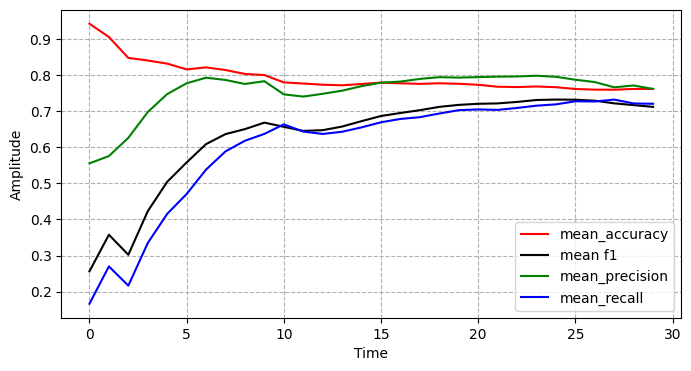

In [21]:
import matplotlib.pyplot as plt

print(f"Mean Accuracy:  {mean_accuracy[-1]:.3f}")
print(f"Mean F1 Score:  {mean_f1[-1]:.3f}")
print(f"Mean Precision: {mean_precision[-1]:.3f}")
print(f"Mean Recall:    {mean_recall[-1]:.3f}")

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_accuracy, color = "red",label=f"mean_accuracy")
plt.plot(mean_f1, color = "black",label=f"mean f1")
plt.plot(mean_precision, color = "green",label=f"mean_precision")
plt.plot(mean_recall, color = "blue",label=f"mean_recall")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()